In [30]:
#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history, title):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

In [24]:
import pandas as pd
import numpy as np
import re
import collections

Tweet = pd.read_csv('data/Tweets.csv', 'utf-8', delimiter=',')


Tweet['sentiment']=Tweet['airline_sentiment'].apply(lambda x: {'negative':0, 'neutral':1, 'positive':2}.get(x))
Tweet['cleaned_text'] = Tweet['text'].apply(lambda x: re.sub('[^a-zA-Z\s]','',x ).lower())

In [28]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras import preprocessing
from keras.utils import to_categorical

from keras.models import Sequential
from keras import layers
from keras.utils import plot_model


maxlen = 26
org_sentences = Tweet['cleaned_text'].values
sentences = Tweet['cleaned_text'].values
 

print('Fitted tokenizer on {} documents'.format(tokenizer.document_count))
print('{} words in dictionary'.format(len(word_index)))
print('Top 5 most common words are:', collections.Counter(tokenizer.word_counts).most_common(5))

print(Tweet['text'][0])
print(sentences[0])

sentences = tokenizer.texts_to_sequences(sentences) 
print(sentences[0])

sentences = preprocessing.sequence.pad_sequences(sentences, maxlen=maxlen, padding='post')
word_index = tokenizer.word_index                              
print(sentences[0])
print('Found %s unique tokens.' % len(word_index))

y = Tweet['sentiment'].values
y_encoded = to_categorical(y)


X_train, X_test, y_train, y_test = train_test_split(sentences,y_encoded, test_size=0.2,random_state=42)
_,X_test_sentences,_,_ = train_test_split(org_sentences,y_encoded, test_size=0.2,random_state=42) 

print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

input_dim = X_train.shape[1]  # Number of features
print('Number of input features %d.' % input_dim)

model = Sequential()
model.add(layers.Embedding(len(word_index) + 1, 100, input_length=maxlen))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(256, 5, padding='valid', activation='relu', strides=1))
model.add(layers.MaxPooling1D(pool_size=2, strides=1))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1))
model.add(layers.MaxPooling1D(pool_size=2, strides=1))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()



plot_model(model, to_file='Conv1D-network-with-trainable-embedding.png', show_shapes=True, show_layer_names=True)

history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Fitted tokenizer on 14640 documents
14562 words in dictionary
Top 5 most common words are: [('to', 8643), ('the', 6052), ('i', 5374), ('a', 4545), ('united', 4144)]
@VirginAmerica What @dhepburn said.
virginamerica what dhepburn said
[78, 57, 5989, 216]
[  78   57 5989  216    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Found 14562 unique tokens.
# Train data samples: 11712
# Test data samples: 2928
Number of input features 26.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 26, 100)           1456300   
_________________________________________________________________
dropout_25 (Dropout)         (None, 26, 100)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 22, 256)           128256    
___________________

/common/workspaces/python-workspace/keras_virtual/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11712 samples, validate on 2928 samples
Epoch 1/5
11712/11712 [==============================] - 14s 1ms/step - loss: 0.6782 - accuracy: 0.7148 - val_loss: 0.5152 - val_accuracy: 0.7985
Epoch 2/5
11712/11712 [==============================] - 15s 1ms/step - loss: 0.4486 - accuracy: 0.8285 - val_loss: 0.5391 - val_accuracy: 0.7831
Epoch 3/5
11712/11712 [==============================] - 15s 1ms/step - loss: 0.3091 - accuracy: 0.8837 - val_loss: 0.6075 - val_accuracy: 0.7742
Epoch 4/5
11712/11712 [==============================] - 15s 1ms/step - loss: 0.2105 - accuracy: 0.9244 - val_loss: 0.6569 - val_accuracy: 0.7906
Epoch 5/5
11712/11712 [==============================] - 14s 1ms/step - loss: 0.1574 - accuracy: 0.9450 - val_loss: 0.7636 - val_accuracy: 0.7804
Training Accuracy: 0.9769
Testing Accuracy:  0.7804


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


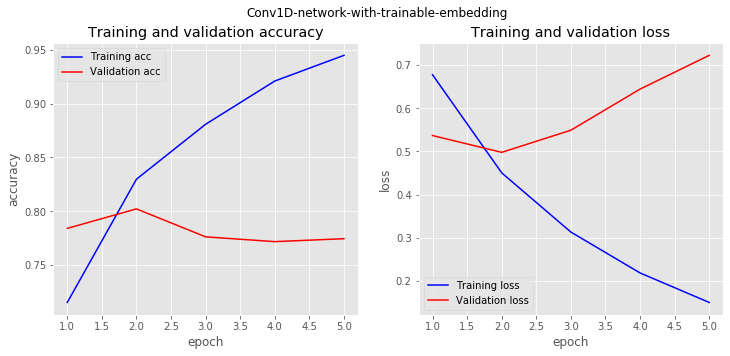

In [26]:
plot_history(history, 'Conv1D-network-with-trainable-embedding')

              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      1889
     neutral       0.59      0.56      0.58       580
     postive       0.64      0.77      0.70       459

    accuracy                           0.78      2928
   macro avg       0.70      0.73      0.71      2928
weighted avg       0.78      0.78      0.78      2928



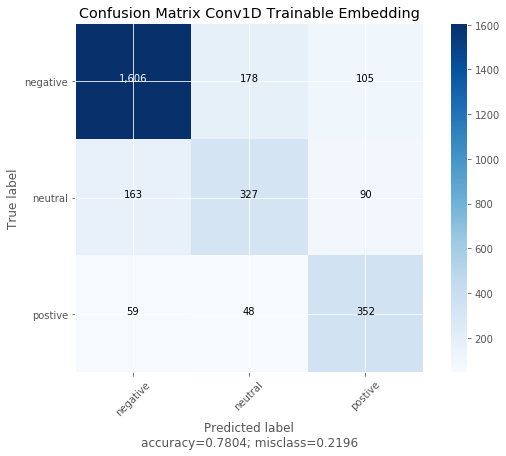

0.5869503440285583

In [32]:
predictions =  model.predict(X_test)

predictions = np.argmax(predictions, axis=1)
y_test_true =  np.argmax(y_test, axis=1)


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

target_names = ['negative', 'neutral', 'postive']
#target_names = ['negative', 'postive']
print(classification_report(y_test_true, predictions, target_names=target_names))
           
cm = confusion_matrix(y_test_true, predictions)
plot_confusion_matrix(cm, normalize=False, target_names = target_names,  title='Confusion Matrix Conv1D Trainable Embedding')

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_true, predictions)

In [ ]:
sample_sentences = np.array(['VirginAmerica Food was good', 'VirginAmerica The flight was vey late', 'VirginAmerica No water in the rest rooms ', ])
sentences = tokenizer.texts_to_sequences(sample_sentences) 
sentences = preprocessing.sequence.pad_sequences(sentences, maxlen=maxlen, padding='post')
predictions = model.predict(sentences)
predictions = np.argmax(predictions, axis=1)
print(predictions)
